# Method 9 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

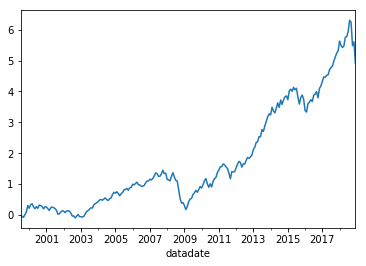

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.309829
2000-12-31   -0.028463
2001-12-31   -0.110295
2002-12-31   -0.162673
2003-12-31    0.481165
2004-12-31    0.237444
2005-12-31    0.090395
2006-12-31    0.110245
2007-12-31    0.119481
2008-12-31   -0.404367
2009-12-31    0.369540
2010-12-31    0.239099
2011-12-31    0.011173
2012-12-31    0.221519
2013-12-31    0.454210
2014-12-31    0.135518
2015-12-31   -0.022342
2016-12-31    0.090114
2017-12-31    0.219365
2018-12-31   -0.061825
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     517.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.11e-113
Time:                        20:18:13   Log-Likelihood:                 650.37
No. Observations:                 234   AIC:                            -1291.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.044      0.003       0.001       0.005
mktrf          1.0040      0.028     35.451      0.000       0.948       1.060
me             0.2964      0.033      8.998      0.000       0.232       0.361
ia            -0.0131      0.050     -0.262      0.793      -0.112       0.086
roe            0.1298      0.043      3.028      0.003       0.045       0.214
==============================================================================
Omnibus:                       90.780   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.086
Skew:                           1.153   Prob(JB):                    9.48e-229
Kurtosis:                      13.119   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     639.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.58e-123
Time:                        20:18:13   Log-Likelihood:                 650.37
No. Observations:                 234   AIC:                            -1291.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.393      0.001       0.001       0.005
mktrf          1.0040      0.041     24.332      0.000       0.923       1.085
me             0.2964      0.037      8.051      0.000       0.224       0.369
ia            -0.0131      0.134     -0.098      0.922      -0.277       0.250
roe            0.1298      0.061      2.118      0.034       0.010       0.250
==============================================================================
Omnibus:                       90.780   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.086
Skew:                           1.153   Prob(JB):                    9.48e-229
Kurtosis:                      13.119   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     934.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.64e-140
Time:                        20:18:13   Log-Likelihood:                 650.37
No. Observations:                 234   AIC:                            -1291.
Df Residuals:                     229   BIC:                            -1273.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.376      0.001       0.001       0.005
mktrf          1.0040      0.044     22.922      0.000       0.918       1.090
me             0.2964      0.036      8.170      0.000       0.225       0.368
ia            -0.0131      0.119     -0.111      0.912      -0.246       0.219
roe            0.1298      0.068      1.916      0.055      -0.003       0.263
==============================================================================
Omnibus:                       90.780   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.086
Skew:                           1.153   Prob(JB):                    9.48e-229
Kurtosis:                      13.119   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     372.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.40e-107
Time:                        20:18:13   Log-Likelihood:                 639.86
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     228   BIC:                            -1247.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.103      0.002       0.001       0.006
mktrf          0.9874      0.030     33.196      0.000       0.929       1.046
smb            0.2922      0.039      7.446      0.000       0.215       0.370
hml           -0.0539      0.046     -1.165      0.245      -0.145       0.037
rmw            0.0598      0.052      1.144      0.254      -0.043       0.163
cma            0.0613      0.067      0.921      0.358      -0.070       0.192
==============================================================================
Omnibus:                       74.603   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.610
Skew:                           0.919   Prob(JB):                    6.09e-159
Kurtosis:                      11.447   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     431.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.56e-114
Time:                        20:18:13   Log-Likelihood:                 639.86
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     228   BIC:                            -1247.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.994      0.003       0.001       0.006
mktrf          0.9874      0.038     25.918      0.000       0.913       1.062
smb            0.2922      0.032      9.023      0.000       0.229       0.356
hml           -0.0539      0.068     -0.797      0.425      -0.186       0.079
rmw            0.0598      0.059      1.022      0.307      -0.055       0.175
cma            0.0613      0.144      0.426      0.670      -0.220       0.343
==============================================================================
Omnibus:                       74.603   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.610
Skew:                           0.919   Prob(JB):                    6.09e-159
Kurtosis:                      11.447   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     439.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.87e-115
Time:                        20:18:13   Log-Likelihood:                 639.86
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     228   BIC:                            -1247.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.064      0.002       0.001       0.006
mktrf          0.9874      0.042     23.515      0.000       0.905       1.070
smb            0.2922      0.030      9.690      0.000       0.233       0.351
hml           -0.0539      0.071     -0.756      0.450      -0.194       0.086
rmw            0.0598      0.057      1.044      0.297      -0.053       0.172
cma            0.0613      0.138      0.444      0.657      -0.209       0.331
==============================================================================
Omnibus:                       74.603   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              728.610
Skew:                           0.919   Prob(JB):                    6.09e-159
Kurtosis:                      11.447   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     577.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.41e-118
Time:                        20:18:13   Log-Likelihood:                 662.01
No. Observations:                 234   AIC:                            -1314.
Df Residuals:                     229   BIC:                            -1297.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.094      0.002       0.001       0.005
mktrf          1.0441      0.025     42.087      0.000       0.995       1.093
smb            0.2007      0.031      6.479      0.000       0.140       0.262
hml            0.0787      0.031      2.557      0.011       0.018       0.139
umd            0.1519      0.020      7.526      0.000       0.112       0.192
==============================================================================
Omnibus:                       56.083   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.423
Skew:                           0.789   Prob(JB):                     2.89e-67
Kurtosis:                       8.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     424.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.24e-104
Time:                        20:18:13   Log-Likelihood:                 662.01
No. Observations:                 234   AIC:                            -1314.
Df Residuals:                     229   BIC:                            -1297.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.001      0.003       0.001       0.005
mktrf          1.0441      0.044     23.977      0.000       0.959       1.129
smb            0.2007      0.043      4.662      0.000       0.116       0.285
hml            0.0787      0.075      1.054      0.292      -0.068       0.225
umd            0.1519      0.046      3.271      0.001       0.061       0.243
==============================================================================
Omnibus:                       56.083   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.423
Skew:                           0.789   Prob(JB):                     2.89e-67
Kurtosis:                       8.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     697.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.51e-127
Time:                        20:18:13   Log-Likelihood:                 662.01
No. Observations:                 234   AIC:                            -1314.
Df Residuals:                     229   BIC:                            -1297.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.011      0.003       0.001       0.005
mktrf          1.0441      0.040     25.944      0.000       0.965       1.123
smb            0.2007      0.046      4.332      0.000       0.110       0.291
hml            0.0787      0.073      1.085      0.278      -0.063       0.221
umd            0.1519      0.046      3.285      0.001       0.061       0.243
==============================================================================
Omnibus:                       56.083   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.423
Skew:                           0.789   Prob(JB):                     2.89e-67
Kurtosis:                       8.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     221.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.40e-53
Time:                        20:18:13   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.008      0.047     4.8e-05       0.007
mktrf          1.0893      0.048     22.747      0.000       0.994       1.184
me             0.3024      0.047      6.393      0.000       0.209       0.396
ia             0.0279      0.074      0.377      0.707      -0.119       0.175
roe            0.2392      0.066      3.649      0.000       0.109       0.369
==============================================================================
Omnibus:                       55.847   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.715
Skew:                           1.382   Prob(JB):                     6.35e-80
Kurtosis:                      11.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     229.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.09e-54
Time:                        20:18:13   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.249      0.025       0.000       0.007
mktrf          1.0893      0.058     18.766      0.000       0.976       1.203
me             0.3024      0.047      6.440      0.000       0.210       0.394
ia             0.0279      0.167      0.167      0.867      -0.300       0.355
roe            0.2392      0.064      3.716      0.000       0.113       0.365
==============================================================================
Omnibus:                       55.847   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.715
Skew:                           1.382   Prob(JB):                     6.35e-80
Kurtosis:                      11.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     361.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.88e-64
Time:                        20:18:13   Log-Likelihood:                 310.56
No. Observations:                 120   AIC:                            -611.1
Df Residuals:                     115   BIC:                            -597.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.337      0.019       0.001       0.007
mktrf          1.0893      0.056     19.579      0.000       0.980       1.198
me             0.3024      0.051      5.967      0.000       0.203       0.402
ia             0.0279      0.142      0.196      0.844      -0.251       0.307
roe            0.2392      0.062      3.835      0.000       0.117       0.361
==============================================================================
Omnibus:                       55.847   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.715
Skew:                           1.382   Prob(JB):                     6.35e-80
Kurtosis:                      11.081   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     149.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.59e-48
Time:                        20:18:13   Log-Likelihood:                 301.88
No. Observations:                 120   AIC:                            -591.8
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.224      0.028       0.000       0.008
mktrf          1.0781      0.055     19.773      0.000       0.970       1.186
smb            0.3092      0.062      5.007      0.000       0.187       0.432
hml           -0.1418      0.076     -1.874      0.064      -0.292       0.008
rmw            0.1869      0.089      2.094      0.038       0.010       0.364
cma            0.1755      0.098      1.796      0.075      -0.018       0.369
==============================================================================
Omnibus:                       34.490   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.112
Skew:                           0.836   Prob(JB):                     7.65e-35
Kurtosis:                       8.350   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     197.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-54
Time:                        20:18:13   Log-Likelihood:                 301.88
No. Observations:                 120   AIC:                            -591.8
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.297      0.022       0.001       0.008
mktrf          1.0781      0.067     16.042      0.000       0.946       1.210
smb            0.3092      0.046      6.765      0.000       0.220       0.399
hml           -0.1418      0.108     -1.309      0.191      -0.354       0.071
rmw            0.1869      0.087      2.156      0.031       0.017       0.357
cma            0.1755      0.171      1.028      0.304      -0.159       0.510
==============================================================================
Omnibus:                       34.490   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.112
Skew:                           0.836   Prob(JB):                     7.65e-35
Kurtosis:                       8.350   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     208.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-55
Time:                        20:18:13   Log-Likelihood:                 301.88
No. Observations:                 120   AIC:                            -591.8
Df Residuals:                     114   BIC:                            -575.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.462      0.014       0.001       0.008
mktrf          1.0781      0.073     14.800      0.000       0.935       1.221
smb            0.3092      0.039      7.861      0.000       0.232       0.386
hml           -0.1418      0.117     -1.215      0.224      -0.371       0.087
rmw            0.1869      0.087      2.147      0.032       0.016       0.357
cma            0.1755      0.165      1.064      0.287      -0.148       0.499
==============================================================================
Omnibus:                       34.490   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.112
Skew:                           0.836   Prob(JB):                     7.65e-35
Kurtosis:                       8.350   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     247.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-55
Time:                        20:18:13   Log-Likelihood:                 316.48
No. Observations:                 120   AIC:                            -623.0
Df Residuals:                     115   BIC:                            -609.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      3.233      0.002       0.002       0.009
mktrf          1.1144      0.040     27.749      0.000       1.035       1.194
smb            0.1466      0.046      3.207      0.002       0.056       0.237
hml            0.0900      0.046      1.964      0.052      -0.001       0.181
umd            0.1856      0.028      6.575      0.000       0.130       0.242
==============================================================================
Omnibus:                       21.436   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.526
Skew:                           0.663   Prob(JB):                     1.07e-11
Kurtosis:                       5.889   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     209.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.31e-52
Time:                        20:18:13   Log-Likelihood:                 316.48
No. Observations:                 120   AIC:                            -623.0
Df Residuals:                     115   BIC:                            -609.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      3.499      0.000       0.002       0.008
mktrf          1.1144      0.059     18.772      0.000       0.998       1.231
smb            0.1466      0.051      2.854      0.004       0.046       0.247
hml            0.0900      0.093      0.965      0.335      -0.093       0.273
umd            0.1856      0.053      3.527      0.000       0.082       0.289
==============================================================================
Omnibus:                       21.436   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.526
Skew:                           0.663   Prob(JB):                     1.07e-11
Kurtosis:                       5.889   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     397.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.72e-66
Time:                        20:18:13   Log-Likelihood:                 316.48
No. Observations:                 120   AIC:                            -623.0
Df Residuals:                     115   BIC:                            -609.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.001      3.638      0.000       0.002       0.008
mktrf          1.1144      0.049     22.974      0.000       1.019       1.209
smb            0.1466      0.050      2.939      0.003       0.049       0.244
hml            0.0900      0.090      1.003      0.316      -0.086       0.266
umd            0.1856      0.046      4.019      0.000       0.095       0.276
==============================================================================
Omnibus:                       21.436   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.526
Skew:                           0.663   Prob(JB):                     1.07e-11
Kurtosis:                       5.889   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     566.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.02e-72
Time:                        20:18:14   Log-Likelihood:                 381.43
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.008      0.000       0.002       0.005
mktrf          0.9241      0.026     36.056      0.000       0.873       0.975
me             0.3073      0.040      7.767      0.000       0.229       0.386
ia            -0.1857      0.055     -3.384      0.001      -0.295      -0.077
roe           -0.1293      0.048     -2.681      0.008      -0.225      -0.034
==============================================================================
Omnibus:                        2.769   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.223
Skew:                          -0.317   Prob(JB):                        0.329
Kurtosis:                       3.256   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     389.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.46e-63
Time:                        20:18:14   Log-Likelihood:                 381.43
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.293      0.001       0.001       0.006
mktrf          0.9241      0.028     33.166      0.000       0.869       0.979
me             0.3073      0.047      6.472      0.000       0.214       0.400
ia            -0.1857      0.068     -2.745      0.006      -0.318      -0.053
roe           -0.1293      0.066     -1.961      0.050      -0.258   -8.05e-05
==============================================================================
Omnibus:                        2.769   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.223
Skew:                          -0.317   Prob(JB):                        0.329
Kurtosis:                       3.256   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     615.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.51e-74
Time:                        20:18:14   Log-Likelihood:                 381.43
No. Observations:                 114   AIC:                            -752.9
Df Residuals:                     109   BIC:                            -739.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.755      0.006       0.001       0.006
mktrf          0.9241      0.025     36.372      0.000       0.874       0.974
me             0.3073      0.047      6.583      0.000       0.216       0.399
ia            -0.1857      0.074     -2.517      0.012      -0.330      -0.041
roe           -0.1293      0.065     -2.004      0.045      -0.256      -0.003
==============================================================================
Omnibus:                        2.769   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.250   Jarque-Bera (JB):                2.223
Skew:                          -0.317   Prob(JB):                        0.329
Kurtosis:                       3.256   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     575.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.12e-76
Time:                        20:18:14   Log-Likelihood:                 394.98
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     108   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.401      0.001       0.001       0.004
mktrf          0.9350      0.022     42.883      0.000       0.892       0.978
smb            0.2692      0.035      7.605      0.000       0.199       0.339
hml           -0.0456      0.045     -1.009      0.315      -0.135       0.044
rmw           -0.2554      0.055     -4.621      0.000      -0.365      -0.146
cma           -0.1416      0.070     -2.017      0.046      -0.281      -0.002
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.613
Skew:                          -0.156   Prob(JB):                        0.446
Kurtosis:                       3.492   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     468.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.74e-71
Time:                        20:18:14   Log-Likelihood:                 394.98
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     108   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.823      0.005       0.001       0.004
mktrf          0.9350      0.026     35.366      0.000       0.883       0.987
smb            0.2692      0.035      7.665      0.000       0.200       0.338
hml           -0.0456      0.039     -1.163      0.245      -0.122       0.031
rmw           -0.2554      0.047     -5.417      0.000      -0.348      -0.163
cma           -0.1416      0.068     -2.069      0.039      -0.276      -0.007
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.613
Skew:                          -0.156   Prob(JB):                        0.446
Kurtosis:                       3.492   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     705.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-80
Time:                        20:18:14   Log-Likelihood:                 394.98
No. Observations:                 114   AIC:                            -778.0
Df Residuals:                     108   BIC:                            -761.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.362      0.018       0.000       0.005
mktrf          0.9350      0.027     34.570      0.000       0.882       0.988
smb            0.2692      0.031      8.588      0.000       0.208       0.331
hml           -0.0456      0.040     -1.145      0.252      -0.124       0.032
rmw           -0.2554      0.040     -6.355      0.000      -0.334      -0.177
cma           -0.1416      0.071     -1.997      0.046      -0.281      -0.003
==============================================================================
Omnibus:                        2.107   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.613
Skew:                          -0.156   Prob(JB):                        0.446
Kurtosis:                       3.492   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     603.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.36e-73
Time:                        20:18:14   Log-Likelihood:                 384.82
No. Observations:                 114   AIC:                            -759.6
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.927      0.057   -4.65e-05       0.003
mktrf          0.9687      0.024     41.088      0.000       0.922       1.015
smb            0.3202      0.037      8.711      0.000       0.247       0.393
hml           -0.0134      0.038     -0.353      0.725      -0.088       0.062
umd            0.0699      0.029      2.448      0.016       0.013       0.127
==============================================================================
Omnibus:                        2.176   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                1.645
Skew:                          -0.190   Prob(JB):                        0.439
Kurtosis:                       3.450   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     584.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-72
Time:                        20:18:14   Log-Likelihood:                 384.82
No. Observations:                 114   AIC:                            -759.6
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.620      0.105      -0.000       0.004
mktrf          0.9687      0.022     44.677      0.000       0.926       1.011
smb            0.3202      0.036      8.810      0.000       0.249       0.391
hml           -0.0134      0.039     -0.344      0.731      -0.090       0.063
umd            0.0699      0.019      3.592      0.000       0.032       0.108
==============================================================================
Omnibus:                        2.176   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                1.645
Skew:                          -0.190   Prob(JB):                        0.439
Kurtosis:                       3.450   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     932.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.69e-83
Time:                        20:18:14   Log-Likelihood:                 384.82
No. Observations:                 114   AIC:                            -759.6
Df Residuals:                     109   BIC:                            -746.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.421      0.155      -0.001       0.004
mktrf          0.9687      0.020     48.147      0.000       0.929       1.008
smb            0.3202      0.038      8.467      0.000       0.246       0.394
hml           -0.0134      0.037     -0.358      0.720      -0.087       0.060
umd            0.0699      0.021      3.307      0.001       0.028       0.111
==============================================================================
Omnibus:                        2.176   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                1.645
Skew:                          -0.190   Prob(JB):                        0.439
Kurtosis:                       3.450   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""